In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import ast
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

In [5]:
train = pd.read_parquet('../data/processed/movies/train.pq')
# train = pd.concat([train,pd.get_dummies(train.original_language)],axis=1)
# train = train.drop('budget', axis=1)
train['revenue'] = np.log1p(train['revenue'])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(train.drop('revenue', axis=1), train['revenue'],
                                                    train_size=0.75, test_size=0.25, random_state=42)

In [7]:
X_train

,is_Fantasy,is_Family,is_War,is_Drama,is_Romance,is_Mystery,is_Thriller,is_Comedy,is_Foreign,is_Horror,...,is_Music,is_TV Movie,is_Documentary,is_Western,is_Action,is_Crime,is_History,is_Animation,budget,original_language
2922,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,en
340,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,en
1099,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,15000000,en
1543,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,en
748,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,ja
1095,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,58000000,en
1130,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,en
1294,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,24000000,en


In [8]:
train_pool = Pool(X_train, y_train,
                  cat_features=['original_language'])
test_pool = Pool(X_test, y_test,
                  cat_features=['original_language'])

In [9]:
model = CatBoostRegressor(iterations=1000, loss_function='RMSE')

In [10]:
fit = model.fit(train_pool, eval_set=test_pool)

0:	learn: 3.0645305	test: 2.9220590	best: 2.9220590 (0)	total: 57.1ms	remaining: 57s
1:	learn: 3.0340011	test: 2.8893450	best: 2.8893450 (1)	total: 59.8ms	remaining: 29.8s
2:	learn: 3.0058765	test: 2.8606124	best: 2.8606124 (2)	total: 62.3ms	remaining: 20.7s
3:	learn: 2.9795359	test: 2.8321059	best: 2.8321059 (3)	total: 65ms	remaining: 16.2s
4:	learn: 2.9524630	test: 2.8041056	best: 2.8041056 (4)	total: 68.3ms	remaining: 13.6s
5:	learn: 2.9282328	test: 2.7778102	best: 2.7778102 (5)	total: 70.6ms	remaining: 11.7s
6:	learn: 2.9044663	test: 2.7527495	best: 2.7527495 (6)	total: 72.9ms	remaining: 10.3s
7:	learn: 2.8814549	test: 2.7290953	best: 2.7290953 (7)	total: 75.2ms	remaining: 9.32s
8:	learn: 2.8612491	test: 2.7080122	best: 2.7080122 (8)	total: 77.4ms	remaining: 8.52s
9:	learn: 2.8404283	test: 2.6855679	best: 2.6855679 (9)	total: 79.7ms	remaining: 7.89s
10:	learn: 2.8206319	test: 2.6650026	best: 2.6650026 (10)	total: 81.8ms	remaining: 7.36s
11:	learn: 2.8020128	test: 2.6450266	best: 2.

In [12]:
loss_stats_train = pd.DataFrame(fit.get_evals_result()['learn']['RMSE'], columns=['loss']).reset_index()
loss_stats_train['type'] = 'train'


loss_stats_test = pd.DataFrame(fit.get_evals_result()['validation']['RMSE'], columns=['loss']).reset_index()
loss_stats_test['type'] = 'validation'

loss_stats = pd.concat([loss_stats_train, loss_stats_test])

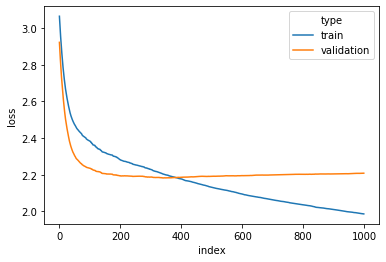

In [13]:
sns.lineplot(x='index', y='loss', hue='type',data = loss_stats)